In [51]:
import chess
import sqlite3
import numpy as np
def board_intersection_metric(fen1, fen2):
    board1: chess.Board = chess.Board(fen1)
    board2: chess.Board = chess.Board(fen2)

    if not board1.turn:
        board1.mirror()

    if not board2.turn:
        board2 = board2.mirror()

    sum = 0
    ## Check white pieces
    for piece in chess.PIECE_TYPES:
        overlap =  board1.pieces_mask(piece, True) & board2.pieces_mask(piece, True)
        sum += bin(overlap).count("1")
    # Check black pieces
    for piece in chess.PIECE_TYPES:
        overlap = board1.pieces_mask(piece, False) & board2.pieces_mask(piece, False)
        sum += bin(overlap).count("1")
    return sum

def board_intersection(fen1, fen2):
    board1: chess.Board = chess.Board(fen1)
    board2: chess.Board = chess.Board(fen2)

    if not board1.turn:
        board1.mirror()

    if not board2.turn:
        board2 = board2.mirror()

    intersection_dict = {}
    for piece in chess.PIECE_TYPES:
        white_overlap =  board1.pieces_mask(piece, True) & board2.pieces_mask(piece, True)
        intersection_dict[(piece, True)] = bitboard_to_bool_array(white_overlap)

        black_overlap = board1.pieces_mask(piece, False) & board2.pieces_mask(piece, False)
        intersection_dict[(piece, False)] = bitboard_to_bool_array(black_overlap)

    return intersection_dict

def bitboard_to_bool_array(bitboard: int) -> np.ndarray:
    """Convert a 64-bit bitboard to an 8x8 NumPy boolean array (rank 8 to 1, file A to H)."""
    flat = np.array([(bitboard >> i) & 1 for i in range(64)], dtype=bool)
    return flat.reshape((8, 8))[::-1]  # Flip vertically to get rank 8 at the top


table_name = "JumpReluCoordinateTrainer02031730"

def get_db_conn():
    conn = sqlite3.connect("/home/zachary/PycharmProjects/SparseMate/SparseMate.sqlite")
    return conn

query = f"""SELECT fen, sq, feature, value from {table_name} where feature = 43;"""

connection  = get_db_conn()

results = connection.cursor().execute(query).fetchall()

fen_set = set()

for row in results:
    fen = row[0]
    fen_set.add(fen)

piece_intersection_distribution = {}

for piece in chess.PIECE_TYPES:
    piece_intersection_distribution[(piece, True)] = np.zeros(shape=(8,8))
    piece_intersection_distribution[(piece, False)] = np.zeros(shape=(8,8))
# Copy the set to avoid modifying it while iterating
fen_set_copy = fen_set.copy()

i = 0
for fen in fen_set_copy:
    fen_set.remove(fen)  # Safe removal now
    for compare_fen in fen_set:
        intersection = board_intersection(fen, compare_fen)
        i += 1
        for key, value in intersection.items():
            piece_intersection_distribution[key] += value > 0

pieces = ["PAWN", "KNIGHT", "BISHOP", "ROOK", "QUEEN", "KING"]



In [2]:
import matplotlib.pyplot as plt


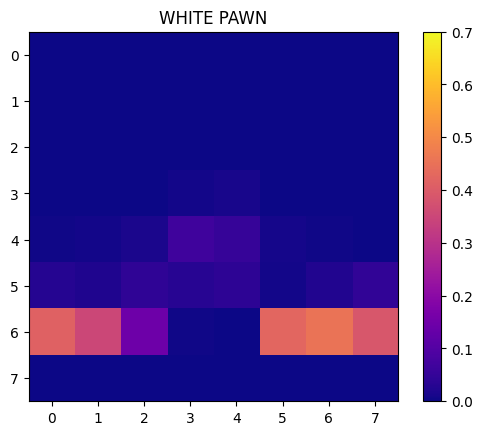

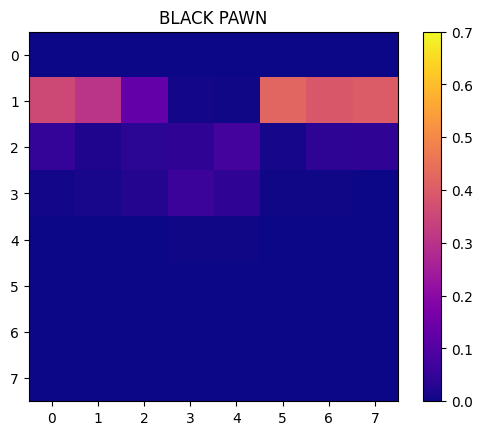

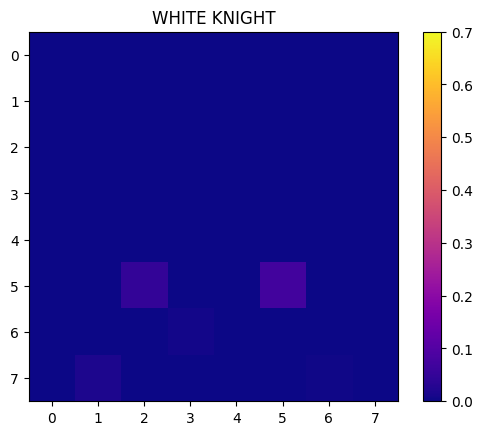

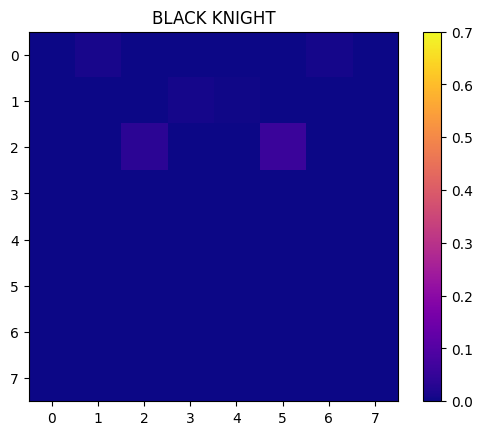

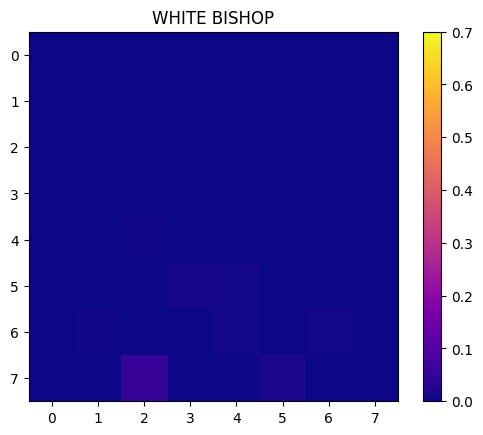

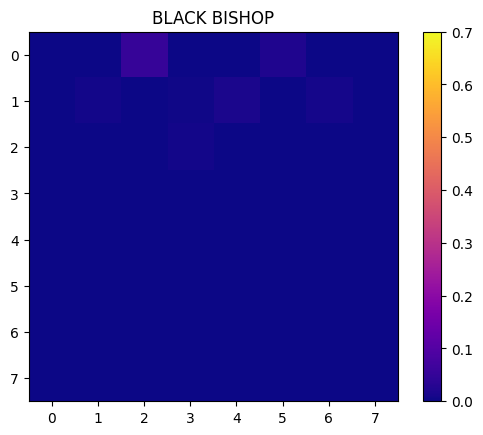

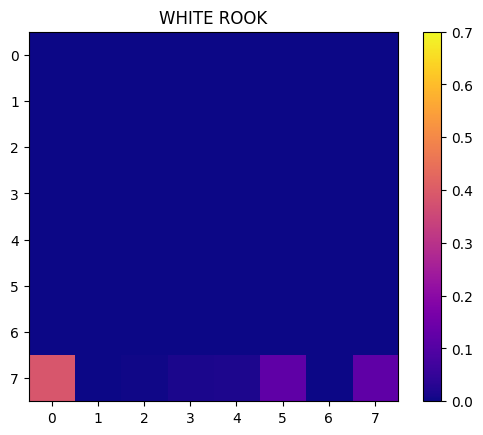

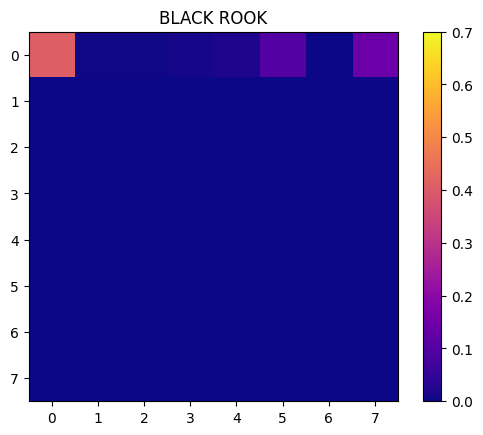

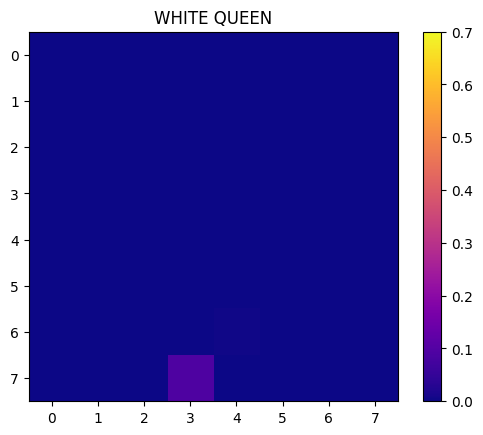

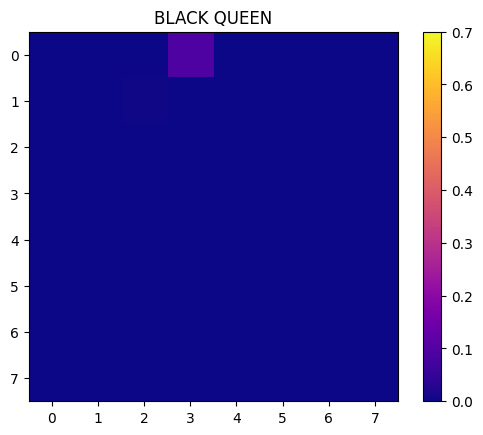

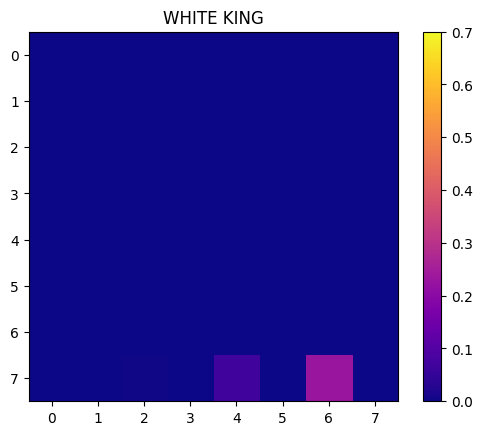

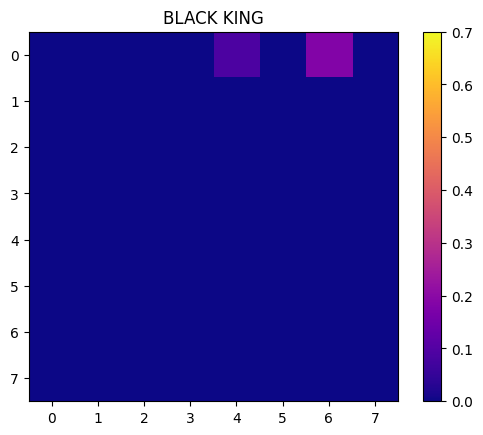

In [52]:
pieces = ["PAWN", "KNIGHT", "BISHOP", "ROOK", "QUEEN", "KING"]

vmax = 0.7

for j in range(1,7):
    plt.imshow(piece_intersection_distribution[(j,True)]/i, cmap = 'plasma', vmin = 0, vmax = vmax)
    plt.title("WHITE " + pieces[j - 1])
    plt.colorbar()
    plt.show()

    plt.imshow(piece_intersection_distribution[(j,False)]/i, cmap = 'plasma', vmin = 0, vmax = vmax)
    plt.title("BLACK " + pieces[j - 1])
    plt.colorbar()
    plt.show()